<a href="https://colab.research.google.com/github/seecode4/seeRepo1/blob/main/capstone/prototype_to_scale/prototype_triviaqa_llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Capstone Step8 - ML Prototype for Scaling

Here packages to be installed are in requirements.txt. </br> Ollama server will be used to pull Large Language Models to query using the triviaqa dataset. In this example we use llama3.1:8b. The dataset used here was download to a local GDrive from the [github reference](https://github.com/mandarjoshi90/triviaqa) for the paper "TriviaQA: A Large Scale Distantly Supervised Challenge Dataset for Reading Comprehension".  

Following are the steps.

1. Read a trivia-qa json file to get questions and answer from triviaqa data set. Use ijson, since the files can be large and the number of questions can be in the thousands. By default we will use wikipedia_dev_qa.json from the triviaqa dataset.
2. Save the data in a dict. list containing the follwing fields for further use.
3. Install ollama and start the backend server locally in a separate thread
4. Use ollama api to pull the desired LLM. By default, we will pull llama3.1:8b. This is the smaller of the llama models. This would be relatively less demanding on memory and compute resources for this project.
5. In this example, we will query a small number of questions in the dataset
6. The 'Normalized Answer' in the original dataset is the ground truth and is included in the 'Normalized Aliases', with acceptable answers res
7. For each Answer from the llm, we will normalize the Answer and compare it to the "Normalized Aliases'
8. To evaluate, if there is an exact match we will give a score of 1. If not, we will use the Bilingual Evaluation Understudy (BLEU) score 1-gram metric since triviaqa anwers are short and often just 1 or 2 words.

In [2]:
# Mount google drive and copy needed files to the local space
%cd /content/for_step8_scale
!ls -lrt /content/for_step8_scale /content/for_step8_scale/data

/content/for_step8_scale
/content/for_step8_scale/data:
total 16916
-rw------- 1 root root 17318460 Dec 14 03:55 wikipedia-dev.json

/content/for_step8_scale:
total 40
-rw------- 1 root root  5984 Dec 11 04:54 triviaqa_ijson_utils.py
-rw------- 1 root root   661 Dec 14 00:53 Dockerfile.txt
-rw------- 1 root root   108 Dec 14 00:54 my_bash.sh.txt
drwx------ 2 root root  4096 Dec 14 03:55 data
-rw------- 1 root root   115 Dec 14 22:36 requirements.txt
-rw------- 1 root root  2971 Dec 15 00:43 qa_metrics_utils.py
-rw------- 1 root root 10756 Dec 15 00:44 app_ijson_ollama.py


At the start: Connect to a T4-TPU

Available: 77.52 compute units  

In [ ]:
# !cat /proc/meminfo

In [3]:
# sudo apt install pciutils from terminal for each new runtime session
!lspci
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

00:00.0 Host bridge: Intel Corporation 440FX - 82441FX PMC [Natoma] (rev 02)
00:01.0 ISA bridge: Intel Corporation 82371AB/EB/MB PIIX4 ISA (rev 03)
00:01.3 Bridge: Intel Corporation 82371AB/EB/MB PIIX4 ACPI (rev 03)
00:03.0 Non-VGA unclassified device: Red Hat, Inc. Virtio SCSI
00:04.0 3D controller: NVIDIA Corporation TU104GL [Tesla T4] (rev a1)
00:05.0 Ethernet controller: Red Hat, Inc. Virtio network device
00:06.0 Unclassified device [00ff]: Red Hat, Inc. Virtio RNG
Sun Dec 15 00:47:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |

In [4]:
# Install dependencies as would be RUN from a Dockerfile
!cat requirements.txt
!pip install --no-cache-dir -r requirements.txt

ijson==3.3.0
numpy==1.26.4
pandas==2.2.2
matplotlib==3.8.0
ollama==0.4.2
nltk==3.9.1
tensorflow==2.17.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 274.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 277.3 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1


In [5]:
%%time
# Install ollama
from IPython.display import clear_output
!curl -fsSL https://ollama.com/install.sh | sh
clear_output()

CPU times: user 721 ms, sys: 97 ms, total: 818 ms
Wall time: 59.4 s


In [15]:
%%time
# Command to run python file as from a Docker container
!python app_ijson_ollama.py -h
# !pwd
# !ls -lrt *

2024-12-15 01:45:32.281157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-15 01:45:32.299798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-15 01:45:32.305925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 01:45:32.319913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-15 01:45:33.531817: W tensorflow/comp

If redirecting output  
  python app_ijson_ollama.py > output_app.txt 2>&1

At the Terminal </br>
- can look for output_ollama_rm.txt; indicates it is done </br>
- ps -aux |grep ollama and kill -9 <pid>

In [16]:
%%time
# Try default settings just 2 questions - takes about 2min incl. pull model
!python app_ijson_ollama.py > output_app.txt 2>&1

CPU times: user 595 ms, sys: 98.8 ms, total: 694 ms
Wall time: 1min 46s


In [17]:
!ls -lrt ./data
!cat ./test/test-llama3.1\:8b-wikipedia-dev.json

total 16916
-rw------- 1 root root 17318460 Dec 14 03:55 wikipedia-dev.json
[
{"NormalizedAliases": ["sunset boulevard", "sunset bulevard", "west sunset boulevard", "sunset blvd"], "NormalizedValue": "sunset boulevard", "Value": "Sunset Boulevard", "Question": "Which Lloyd Webber musical premiered in the US on 10th December 1993?", "GotAnswer": "Sunset Boulevard", "TimetoAnswer": "7.904", "GotNormalizedValue": "sunset boulevard", "MetricBLEUscore": 1},
{"NormalizedAliases": ["henry campbell bannerman", "sir henry campbell bannerman", "campbell bannerman"], "NormalizedValue": "campbell bannerman", "Value": "Campbell-Bannerman", "Question": "Who was the next British Prime Minister after Arthur Balfour?", "GotAnswer": "Henry Campbell-Bannerman", "TimetoAnswer": "0.257", "GotNormalizedValue": "henry campbell bannerman", "MetricBLEUscore": 1}
]

Available: 76.87 compute units</br>


In [18]:
!ls -lrt
!more test/output_ollama_list.txt
!more test/output_ollama_pull.txt

total 548
-rw------- 1 root root   5984 Dec 11 04:54 triviaqa_ijson_utils.py
-rw------- 1 root root    661 Dec 14 00:53 Dockerfile.txt
-rw------- 1 root root    108 Dec 14 00:54 my_bash.sh.txt
drwx------ 2 root root   4096 Dec 14 03:55 data
-rw------- 1 root root    115 Dec 14 22:36 requirements.txt
drwxr-xr-x 2 root root   4096 Dec 15 00:53 test
-rw-r--r-- 1 root root 260913 Dec 15 01:16 output_app100.txt
-rw------- 1 root root  10840 Dec 15 01:44 app_ijson_ollama.py
-rw------- 1 root root   3327 Dec 15 01:44 qa_metrics_utils.py
drwxr-xr-x 2 root root   4096 Dec 15 01:45 __pycache__
-rw-r--r-- 1 root root   2396 Dec 15 01:47 wikipedia-dev.jsonbar_plot.png
-rw-r--r-- 1 root root 233615 Dec 15 01:47 output_app.txt
NAME           ID              SIZE      MODIFIED      
llama3.1:8b    46e0c10c039e    4.9 GB    5 seconds ago    


In [19]:
%%time
# Try a 100 questions
!python app_ijson_ollama.py -v 1 -n 100 > output_app100.txt 2>&1

CPU times: user 781 ms, sys: 110 ms, total: 891 ms
Wall time: 2min 17s


Available: 77.52 compute units

In [22]:
!wc test/test-llama3.1\:8b-wikipedia-dev.json
!tail -22 output_app100.txt

  101  5499 49461 test/test-llama3.1:8b-wikipedia-dev.json

Done qa evaluation for wikipedia-dev.json ....
--------------------
Num qa: 100, Got correct ans for 55 (55.00%)
bins
(-0.001, 0.2]    31
(0.2, 0.4]        3
(0.4, 0.6]        8
(0.6, 0.8]        3
(0.8, 1.0]       55
Name: count, dtype: int64
--------------------
Figure(640x480)

Done ollama llama3.1:8b rm
Ollama server stopped successfully.

Stopping ollama server..

Stopping ollama thread.. 
ps and delete ollam process if running again
copy /content/for_step8_scale/test/test-llama3.1:8b-wikipedia-dev.json to local drive space


### The following can be done as a separate exercise, since the results are saved in a file. See example below.

In [3]:
# Copy result file to display metrics
%cd /content/for_step8_scale
!ls -l . test

/content/for_step8_scale
.:
total 16
-rw------- 1 root root 3328 Dec 15 06:08 qa_metrics_utils.py
drwxr-xr-x 2 root root 4096 Dec 15 06:13 test
-rw------- 1 root root 5984 Dec 11 04:54 triviaqa_ijson_utils.py

test:
total 52
-rw------- 1 root root 49461 Dec 15 01:53 test-llama3.1:8b-wikipedia-dev.json


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.8 MB/s eta 0:00:00
--------------------
Num qa: 100, Got correct ans for 55 (55.00%)
bins
(-0.001, 0.2]    31
(0.2, 0.4]        3
(0.4, 0.6]        8
(0.6, 0.8]        3
(0.8, 1.0]       55
Name: count, dtype: int64
--------------------


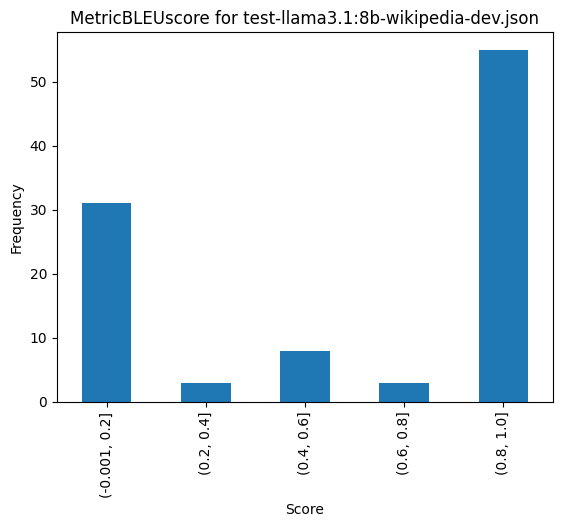

<Figure size 640x480 with 0 Axes>

In [4]:
!pip install ijson
import json
import ijson
import triviaqa_ijson_utils
from triviaqa_ijson_utils import read_dict_list_from_json_file
import qa_metrics_utils
from qa_metrics_utils import display_metrics

qa_filename = "test-llama3.1:8b-wikipedia-dev.json"
fname = "/content/for_step8_scale/test/"+qa_filename
maxnumq = 100
qa_dict_list = read_dict_list_from_json_file(fname, maxnumq)
do_plot = 1
dbglevel = 1
bin_counts, b64_string = display_metrics(qa_dict_list[:maxnumq],
                                         'MetricBLEUscore', qa_filename,
                                         dbglevel, do_plot)
